In [1]:
import json
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
# set global vars
DATA_FILE_JSON = "data.json"
DATA_FILE_SUMMARY = "summary"

In [3]:
# Load the summary to identify files to follow
#
# Assumes summary format is in this order
#     trivial:    -> all trivial moves
#                 order of:
#                     job [src_level]->[dest_level] [src_table]->[dest_table]
#                     R: [zone_resets]
#     flush:      -> all flushes
#                 order of:
#                     job [table]
#                     R: [zone_resets]
#     compaction: -> all compactions
#                 order of:
#                     job src_level->dest_level [src_tables] | [merge_tables] -> [dest_tables] 
#                     D: [table_deletes]
#                     R: [zone_resets]

summary_dict = dict()

with open(DATA_FILE_SUMMARY) as sum_file:
    trivial = False
    flush = False
    compaction = False
    summary_dict["trivial"] = dict()
    summary_dict["flush"] = dict()
    summary_dict["compaction"] = dict()
    job_stack = []

    
    for line in sum_file:
        if trivial:
            if "flush:" in line:
                trivial = False
                flush = True
            else:
                line_split = line.split()
                if "R" in line:
                    summary_dict["trivial"][job_stack.pop()]["resets"] = eval(line[line.find("["):line.find("]")+1])
                else:
                    job = line_split[0]
                    summary_dict["trivial"][job] = dict()
                    job_stack.append(job)
                    levels = list(map(int, re.findall(r'\d+', line_split[1])))
                    summary_dict["trivial"][job]["src_level"] = levels[0] 
                    summary_dict["trivial"][job]["dest_level"] = levels[1]

                    # Tables are identical as the moves are trivial
                    tables = line[line.find("["):line.find("]")+1]
                    summary_dict["trivial"][job]["tables"] = eval(tables)
            
        elif flush:
            if "compaction:" in line:
                flush = False
                compaction = True
            else:
                line_split = line.split()
                if "R" in line:
                    summary_dict["flush"][job_stack.pop()]["resets"] = eval(line[line.find("["):line.find("]")+1])
                else:
                    job = line_split[0]
                    job_stack.append(job)
                    summary_dict["flush"][job] = dict()
                    summary_dict["flush"][job]["table"] = int(line[line.find("[")+2:line.find("]")-1]) # strip the ' char

        elif compaction:
            line_split = line.split()

            if "R" in line:
                summary_dict["compaction"][job_stack.pop()]["resets"] = \
                    eval(line[line.find("["):line.find("]")+1])
            elif "D" in line:
                job = job_stack.pop()
                job_stack.append(job)
                summary_dict["compaction"][job]["resets"] = \
                    eval(line[line.find("["):line.find("]")+1])
            else:
                job = line_split[0]
                summary_dict["compaction"][job] = dict()
                job_stack.append(job)
                levels = list(map(int, re.findall(r'\d+', line_split[1])))
                summary_dict["compaction"][job]["src_level"] = levels[0] 
                summary_dict["compaction"][job]["dest_level"] = levels[1]
                table_split = line.split("|")
                src_tables = line[table_split[0].find("["):table_split[0].find("]")+1]
                summary_dict["compaction"][job]["src_tables"] = eval(src_tables)
                info = table_split[1].split("->")
                summary_dict["compaction"][job]["merge_tables"] = eval(info[0])
                summary_dict["compaction"][job]["dest_tables"] = eval(info[1])

        if "trivial:" in line:
            trivial = True

In [4]:
# Load the json data
file = open(DATA_FILE_JSON) 
json_data = json.load(file)

In [5]:
# Set configuration variables for plotting

MAX_TIMEUNITS = 2 # Set the number of time units to show (i.e., operations; flush, compaction, trivial, F2FS GC)
TRACE_FILE = 15 # Number of the SST file to trace

In [6]:
class Zone:
    def __init__(self, zone, temperature, status, file):
        self.zone = zone
        self.temperature = temperature
        self.status = status # Valid, Invalid, Reset
        self.files = []
        self.files.append(file)
        
    def __str__(self):
        return f"Zone Number: {self.zone}, Temp: {self.temperature}, Status: {self.status}, Files: {self.files}\n"

In [7]:
class TimeUnit:
    def __init__(self, id, job, operation):
        self.id = id
        self.operation = operation
        self.job = job
        self.zones = []
        self.files = []
        
    def __str__(self):
        msg = f"ID: {self.id}, Job: {self.job}, OP: {self.operation}, Files: {self.files}\n"
        msg += f"Total Zones: {len(self.zones)}\n"
        for zone in self.zones:
            msg += str(zone)
        return msg
    
    def addfile(self, file):
        self.files.append(file)
    
    def addzone(self, zoneid, temperature, status, file):
        self.zones.append(Zone(zoneid, temperature, status, file))
        if not file in self.files:
            self.files.append(file)
        
    def haszone(self, zoneid):
        for zone in self.zones:
            if zoneid == zone.zone:
                return True
        return False
    
    def getzone(self, zoneid):
        for zone in self.zones:
            if zoneid == zone.zone:
                return zone
        return None
        

In [8]:
timeline = []
timectr = 0
maxzone = 0 # highest zone to plot to

# Ignore trivial moves as they do not modify anything in the storage
for i in range(MAX_TIMEUNITS):    
    for op, item in summary_dict.items():
        if op == "flush":
            for job, data in item.items():
                if TRACE_FILE == data["table"]:
                    timeline.append(TimeUnit(timectr, job, "flush"))
                    
                    # find the zone in the operation
                    for entry in json_data[job]["f2fs_file_snapshot_after"]:
                        if f"0{TRACE_FILE}.sst" in entry["filename"]:
                            for zone in entry["hint"]:
                                if not timeline[timectr].haszone(zone[0]):
                                    timeline[timectr].addzone(zone[0], zone[1], "Valid", TRACE_FILE)
                                    if zone[0] > maxzone:
                                        maxzone = zone[0]
                    timectr+=1
    
        if op == "compaction":
            for job, data in item.items():
                if TRACE_FILE in data["src_tables"]:
                    timeline.append(TimeUnit(timectr, job, "compaction"))
                    for destination in data["dest_tables"]:
                    
                        # find the zone in the operation
                        for entry in json_data[job]["f2fs_file_snapshot_after"]:
                            if f"0{destination}.sst" in entry["filename"]:
                                for zone in entry["hint"]:
                                    if not timeline[timectr].haszone(zone[0]):
                                        timeline[timectr].addzone(zone[0], zone[1], "Valid", destination)
                                        if zone[0] > maxzone:
                                            maxzone = zone[0]
                    timectr+=1

# TODO: zone status, change to reset or so

# TO DEBUG (Use each to draw one point, all fields should have info to know what to draw/connect)
print(timeline[0])

ID: 0, Job: 11, OP: flush, Files: [15]
Total Zones: 2
Zone Number: 4, Temp: CURSEG_WARM_DATA, Status: Valid, Files: [15]
Zone Number: 7, Temp: CURSEG_WARM_DATA, Status: Valid, Files: [15]



11
ID: 0, Job: 11, OP: flush, Files: [15]
Total Zones: 2
Zone Number: 4, Temp: CURSEG_WARM_DATA, Status: Valid, Files: [15]
Zone Number: 7, Temp: CURSEG_WARM_DATA, Status: Valid, Files: [15]

15
... 4 [15] 15
... 7 [15] 15
ID: 1, Job: 17, OP: compaction, Files: ['21', '22']
Total Zones: 4
Zone Number: 5, Temp: CURSEG_COLD_DATA, Status: Valid, Files: ['21']
Zone Number: 8, Temp: CURSEG_HOT_DATA, Status: Valid, Files: ['21']
Zone Number: 10, Temp: CURSEG_COLD_DATA, Status: Valid, Files: ['21']
Zone Number: 11, Temp: CURSEG_COLD_DATA, Status: Valid, Files: ['22']

21
22
... 5 ['21'] 21
... 8 ['21'] 21
... 10 ['21'] 21
... 11 ['22'] 22
timepoint 0
ID: 2, Job: 11, OP: flush, Files: [15]
Total Zones: 2
Zone Number: 4, Temp: CURSEG_WARM_DATA, Status: Valid, Files: [15]
Zone Number: 7, Temp: CURSEG_WARM_DATA, Status: Valid, Files: [15]

15
... 4 [15] 15
... 7 [15] 15
timepoint 2
ID: 3, Job: 17, OP: compaction, Files: ['21', '22']
Total Zones: 4
Zone Number: 5, Temp: CURSEG_COLD_DATA, Status: V

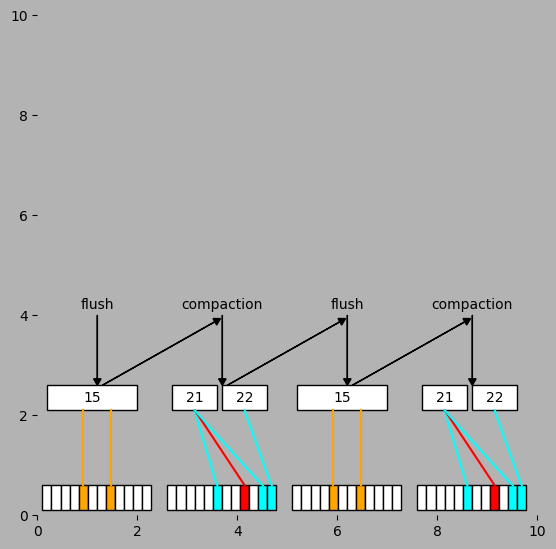

In [81]:
fig = plt.figure(figsize=(5, 5), facecolor="0.7") # For debugging made it gray and show ticks so we see things. drop later!
ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1) #, xticks=[], yticks=[])

color_mapping = {
    'CURSEG_WARM_DATA': 'ORANGE',
    'CURSEG_HOT_DATA': 'RED',
    'CURSEG_COLD_DATA': 'CYAN'
}

gridsize = 2
# print(maxzone)
for timepoint, timeunit in zip(range(len(timeline)), timeline):
    # Add all zones at time point
#     print(timeunit)
    zonewidth = gridsize/maxzone    
    filewidth = (gridsize / len(timeunit.files))
    files = {}
    for x, file in zip(range(len(timeunit.files)), timeunit.files):
#         print(file)
        ax.add_patch(Rectangle((gridsize*timepoint+ 0.5*timepoint+x*filewidth+0.2, 2.1), filewidth*0.9, 0.5,
                     edgecolor = 'black',
                     facecolor = 'white',
                     fill=True,
                     lw=1))
        if filewidth > 0.20:
            ax.annotate(str(file),
                xy=(gridsize*timepoint+ 0.5*timepoint+x*filewidth+0.2 + filewidth*0.9*0.5, 2.1+0.25), ha='center', va='center')
        files[file] = (gridsize*timepoint+ 0.5*timepoint+x*filewidth+0.2, 2.1)    
    for i in range(maxzone+1):
        color = color_mapping[timeunit.getzone(i).temperature] if timeunit.haszone(i) else 'white'
        ax.add_patch(Rectangle((i*zonewidth+0.1 + gridsize*timepoint + 0.5*timepoint, 0.1), zonewidth, 0.5,
                     edgecolor = 'black',
                     facecolor = color,
                     fill=True,
                     lw=1))
        if timeunit.haszone(i):
            zonefiles = timeunit.getzone(i).files
            for file in zonefiles:
                zx = i*zonewidth+0.1 + gridsize*timepoint + 0.5*timepoint + 0.5 * zonewidth
                zy = 0.6
                print('...', i, zonefiles, file)
                fx = files[file][0]
                if fx < zx and fx + filewidth*0.9 > zx:
                    fx = zx
                else:
                    fx = fx + filewidth*0.9*0.5
                fy = files[file][1]
                ax.plot([zx,fx], [zy, fy], color=color)
    if timepoint != 0:
#             print('timepoint', (timepoint-1)*gridsize)
#             ax.plot([0.2+gridsize*0.5 + (timepoint-1)*gridsize*1.25+0.1, 
#                      0.2+gridsize*0.5 + (timepoint)*gridsize*1.25],
#                     [2.6, 4],
#                     color='black')

            ax.arrow(x=0.2+gridsize*0.5 + (timepoint-1)*gridsize*1.25+0.1, 
                     dx=-0.15 + 0.2+gridsize*0.5 + (timepoint)*gridsize*1.25 - (0.2+gridsize*0.5 + (timepoint-1)*gridsize*1.25+0.1),
                    y=2.6, dy=1.4-0.13,
                    color='black', head_width=0.15, head_length=0.13)
    ax.arrow(x=0.2+gridsize*0.5+ timepoint*gridsize*1.25, 
             dx=0, y=4, dy=-1.4+0.13, color='black', head_width=0.15, head_length=0.13)
    ax.annotate(str(timeunit.operation),
                xy=(0.2+gridsize*0.5+ timepoint*gridsize*1.25,4.2), ha='center', va='center')
        
ax.set_ylim(bottom=0, top=10)
ax.set_xlim(0,10)

plt.show()